In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class int_map():
    def __init__(self, d_min, d_max) -> None:
        self.d_min = d_min
        self.num_actions = (d_max - d_min) + 1
        #print(self.num_actions)


    def __call__(self, x) -> int:
        return x - self.d_min
    
    @property
    def n(self):
        return self.num_actions 
    
a = int_map(-1,1)
print(a(1), a.n)

2 3


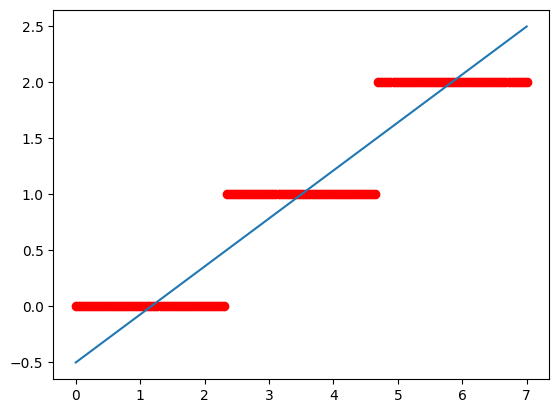

In [4]:
class lin_map():
    def __init__(self, d_min, d_max, num_seg) -> None:
        self.num_seg = num_seg
        half_seg = (d_max-d_min) / (num_seg ) / 2
        self.min_max_mod  = [d_min + half_seg, d_max - half_seg*(0.999)]
        self.minmax = [d_min, d_max]
        self.calc_coefficients(*self.min_max_mod, num_seg-1)

    def calc_coefficients(self,mn,mx,ns):
        a = (ns )/(mx - mn)
        b =  - a*mn
        self.a, self.b = a,b

    def __call__(self, x) -> int:
        return int(self.a*x + self.b + 0.5)
    
    @property
    def n(self):
        return self.num_seg

n_seg = 3
di,df =0,7

l = lin_map(di,df,n_seg)
x2 = np.linspace(di,df, 150)
plt.scatter(x2, [l(i) for i in x2], c = 'r')
plt.plot(x2, [l.a * i + l.b for i in x2])
dx_seg = (df-di) / n_seg


In [5]:
class multi_tile():
    def __init__(self, num_tiles, dtypes, domain) -> None:
        self.num_tiles = num_tiles
        self.domain = domain
        # self.dims   = len(self.domain[0])
        self.dtypes  = dtypes
        self.dims   = len(domain)
        self.tiles = []
        self.cr8_maps()
        #print(self.l_maps);#print(self.ni)
        self.node_ids()
        
    def node_ids(self):
        self.ni = []
        i = 0
        for layer in self.l_maps:
            dims = []
            for dir in layer:
                dims.append(dir.n)
            a = np.arange(np.prod(dims)).reshape(dims) + i
            self.ni.append(a)
            i  = a.max() + 1
        self.max_tiling_ID = i
    
    def extended_domain(self, mn, mx, tile, offset, num_segments):
        domain_length = (mx-mn)
        dx = domain_length*offset # offset for each layer 
        Dx_left = (self.num_tiles - (tile + 1))*dx # - offset2 # tile indexing from 0
        Dx_right = tile * dx 
        segment_size = domain_length / num_segments
        extended_domain = [mn - Dx_left  , mx + Dx_right]
        additional_segments = np.round((Dx_left + Dx_right)/segment_size + 0.5).astype(int)

        return extended_domain, num_segments + additional_segments

    def cr8_maps(self):
        a = []
        for i in range(self.num_tiles):
            a.append([])
            for j in range(self.dims):
                mn,mx = self.domain[j][:2]
                if self.dtypes[j] == 'float':
                    segs  =  self.domain[j][2][i]
                    offset = self.domain[j][3]
                    (mn,mx), segs = self.extended_domain(mn,mx, i, offset, segs)
                    a[i].append(lin_map(mn, mx, segs))
                else:
                    a[i].append(int_map(mn,mx))
        self.l_maps = a
    
    def get_idx(self, pt):
        a =[]
        for i in range(self.num_tiles):
            a.append([])
            for j in range(self.dims):
                k = self.l_maps[i][j](pt[j])
                a[i].append(k)
            
        return [self.ni[i][tuple(a[i])] for i in range(self.num_tiles)]

8.75

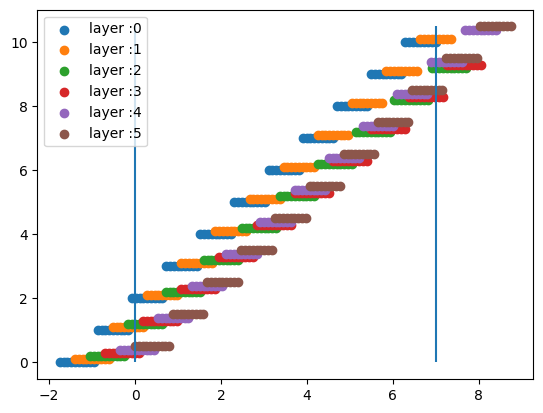

In [6]:
tiles_num = 6; dtypes = ['float']; params = [[0, 7, [8]*tiles_num, 0.05]]
mt = multi_tile(tiles_num,dtypes,params)
k = 0
m = 0
for s,t in enumerate(mt.l_maps):
    l_map = t[0]
    mn,mx = l_map.minmax
    x = np.linspace(mn, mx,100)
    y = [l_map(i)+0.1*s for i in x]

    plt.scatter(x,y, label= f'layer :{s}')
    m = max(m,max(y))

plt.vlines(params[0][:2], 0, m);
plt.legend();
mx

In [47]:
print(mt.get_idx((0,)),mt.get_idx((7,)))

[2, 12, 23, 32, 42, 53] [10, 21, 31, 40, 51, 61]


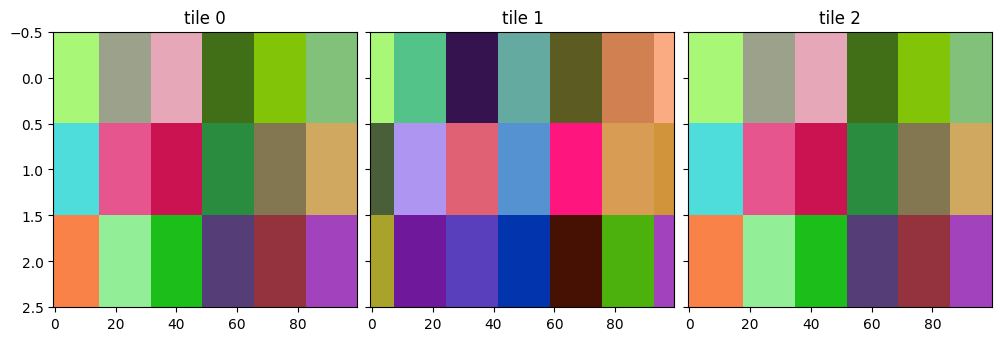

In [48]:
tiles_num = 3;
nt = 5
dt = 'float'
dt2 = 'int'#'float'
dom1 = [0, 7, [nt]*tiles_num, 0.1]
dom2 = [-1,1]
dtypes = [dt,dt2]; params = [dom1,dom2]
mt = multi_tile(tiles_num,dtypes,params)
N = 100
b = np.zeros((tiles_num, N,3), dtype = int)
d0 = [dom1[0], dom2[0]]
dxs = [(dom1[1] - dom1[0])/N,1]


for i,j in np.ndindex(b.shape[1:]):
    b[:,i,j] = mt.get_idx((d0[0] + i*dxs[0], d0[1] + j*dxs[1]))

import matplotlib.colors as mcolors

unique_values = np.unique(b)
num_unique_values = len(unique_values)
colors = np.random.rand(num_unique_values, 3)
color_dict = {val: color for val, color in zip(unique_values, colors)}
color_list = [color_dict[val] for val in unique_values]
custom_cmap = mcolors.ListedColormap(color_list)
fig, ax = plt.subplots(1,tiles_num, figsize = (tiles_num*3.3,3.3), layout='constrained', sharex=1,sharey=1)
i = 0
for m, a in zip(b,ax):
    a.imshow(m.T, cmap=custom_cmap, aspect='auto')
    a.set_title(f'tile {i}')
    i += 1


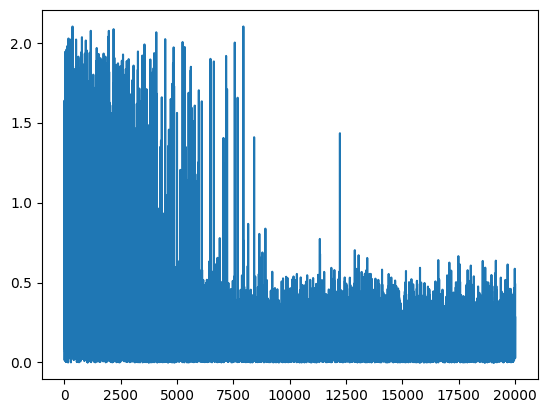

In [85]:
tiles_num = 5;
nt = 40
dt  = 'float'
dt2 = 'float'
dom1 = [0, 2.0 * np.pi, [nt]*tiles_num, 0.1]
dom2 = [0, 2.0 * np.pi, [nt]*tiles_num, 0.1]
dtypes = [dt,dt2]; params = [dom1,dom2]
mt = multi_tile(tiles_num,dtypes,params)

def target_fn(x, y):
  return np.sin(x) + np.cos(y)

def target_fn_noisy(x, y):
  return target_fn(x, y) + 0.1 * np.random.randn()

perf = []
w = np.zeros(mt.max_tiling_ID)
# step size for SGD
alpha = 0.25

# learn from 10,000 samples
for i in range(20000):
   # get noisy sample from target function at random location
  x, y = 2.0 * np.pi * np.random.rand(2)
  target = target_fn_noisy(x, y)
  # get prediction from active tiles at that location
  #active_tiles = get_embed(x,y)
  active_tiles = mt.get_idx((x,y))
  pred = np.sum(w[active_tiles])
  # update weights with SGD
  w[active_tiles] += alpha * (target - pred)
  perf.append(np.abs(target - pred))


plt.plot(perf)


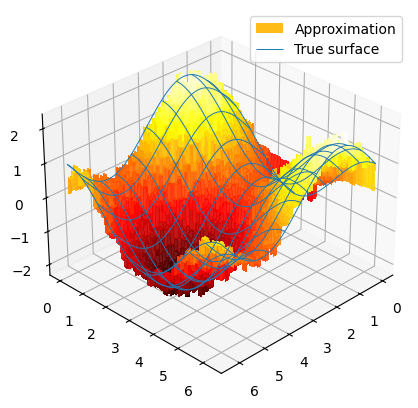

In [86]:
res = 300
x = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
y = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    active_tiles = mt.get_idx((x[i],y[j]))
    z[j,i] = np.sum(w[active_tiles])
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d',computed_zorder=False)
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, z, cmap=plt.get_cmap('hot'), linewidth=1.5, antialiased=False, alpha = 0.9, label='Approximation')
Z = target_fn(X,Y)
ax.plot_wireframe(X, Y, Z, rstride=30, cstride=30, linewidth = 0.7, label='True surface')#, zorder = 100)
ax.view_init(elev=30., azim=45)
plt.legend()
plt.show()

# OLD GARBAGE (PRIVATE, DONT READ)

In [ ]:

ax = None
if 1 == 1:
    1
class tiling():
    def __init__(self, dim_min_max, tiling_ID, idx = None) -> None:
        self.dim_min_max = dim_min_max
        self.ID = tiling_ID
        if ax is not None:
            self.ax = ax
            self.draw_rect(idx)

    def draw_rect(self,idx):
        from matplotlib.patches import Rectangle
        dr = self.dim_min_max[:,1] - self.dim_min_max[:,0]
        corner = self.dim_min_max[:,0]
        rect = Rectangle(corner, *dr, edgecolor='r', facecolor='red', alpha = 0.2)
        self.ax.add_patch(rect)
        self.ax.text(*(corner + 0.5*dr), f'{self.ID}: {idx}')

   
class tile():
    def __init__(self, num_tilings, domain, offset, tile_start_ID = 0, axs = None) -> None:
        self.num_tilings    = num_tilings
        self.domain         = np.array(domain).reshape(-1,2).astype(float)
        self.domain_dims    = self.domain.shape[0]
        self.dx             = (self.domain[:,1] - self.domain[:,0])/num_tilings
        self.eps            = self.dx/1000
        self.domain[:,1]    += self.eps
        self.offset         = np.diag(offset) @ self.dx
        self.axs = axs
        self.ID0 = tile_start_ID

    def create_tile(self):

        IDs = np.arange(self.num_tilings**self.domain_dims).reshape([self.num_tilings]*self.domain_dims)
        IDs += self.ID0
        storage = np.empty(IDs.shape, dtype=object)
        storage2 = np.zeros(IDs.shape + self.domain.shape)
        for index, ID in np.ndenumerate(IDs):
            index =  np.array(index)
            p0 = self.offset + self.domain[:,0] + index*self.dx
            p1 = self.offset + self.domain[:,0] + (index+1)*self.dx
            index = tuple(index)
            minmax = np.array([p0,p1]).T
            storage[index] = tiling(minmax, ID)#, self.axs[self.tile_ID], index)
            storage2[index] = minmax
            
            self.storage = storage
            self.storage2 = storage2
            print(index, ID, *minmax, )#storage[index]
        self.IDs = IDs

        return IDs.max() + 1 

    def find_ID(self, coord):
        d1 = self.domain[:,0] - coord
        d2 = coord - self.domain[:,1]
        assert np.all(d1 < 0) and np.all(d2 < 0), 'Error: value out of domain'
        sl = np.full(self.domain_dims, Ellipsis)
        a = 0
        fail = False
        for d in range(self.domain_dims):
            if fail: break
            sl[d] = Ellipsis
            sl[d+1:] = 0

            for z,t in enumerate(self.storage[tuple(sl)]):
                c_min,c_max = t.dim_min_max[d]
                c_min2,c_max2 = self.storage2[tuple(sl) + (d, z)]
                a += 1
                if c_min <= coord[d] < c_max:
                    sl[d] = z
                    break
                if z == (self.num_tilings-1): fail = True
        if not fail:
            #print(a)
            return self.IDs[tuple(sl)]
        else:
            print('fail!')
    
num_tilings = 2
domain = [[0,1],[1,3],[-1,1]]
offset = [0.0]*len(domain)
#domain = [[0,3]]
t = tile(num_tilings,domain,offset)
aa = t.create_tile()
# pt = [0.1,1.2]#,0.7]

# t.find_ID(pt), t.offset, aa

(0, 0, 0) 0 [0.  0.5] [1. 2.] [-1.  0.]
(0, 0, 1) 1 [0.  0.5] [1. 2.] [0. 1.]
(0, 1, 0) 2 [0.  0.5] [2. 3.] [-1.  0.]
(0, 1, 1) 3 [0.  0.5] [2. 3.] [0. 1.]
(1, 0, 0) 4 [0.5 1. ] [1. 2.] [-1.  0.]
(1, 0, 1) 5 [0.5 1. ] [1. 2.] [0. 1.]
(1, 1, 0) 6 [0.5 1. ] [2. 3.] [-1.  0.]
(1, 1, 1) 7 [0.5 1. ] [2. 3.] [0. 1.]
